In [2]:
using DataFrames
using Gadfly
using GaussianMixtures
using Distributions
using Chemfiles
using StaticArrays
using Colors
using DataStructures
set_default_plot_size(30cm, 12cm)
home = "/home/german/labo/18/lbp/run"
rtdos = "/home/german/labo/18/lbp/rtdos_log"

"/home/german/labo/18/lbp/rtdos_log"

"/home/german/labo/18/lbp/rtdos_log"

In [4]:
# Agarra una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3x3N. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas de carbonos alfa
function format_pca_aa(in_mtx::Array{Float64, 2})
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]

    aa = Int64
    try
        aa = convert(Int64, v_length / 3)
    catch
        error("Vector length: ", v_length, " is not divisible by 3.")
    end

    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    for j = 1:v_nbr
        list_out_mtx[j] = reshape(in_mtx[:, j], 3, aa)
    end

    return list_out_mtx
end


# Agarra la topología una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3xNatomos. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas del pdb q dió lugar a la topología.

# También devuelve un array con el nro de atomos q tiene c/ aa
function format_pca_atom(in_top::Topology, in_mtx::Array{Float64, 2}, mask::Array{Float64, 1} = 0)
    # Preparo variables
    aa = Int64
    aa_3 = Int64
    if mask == 0 
        aa = convert(Int64, count_residues(in_top))
    else
        aa = length(mask)
    end
    aa_3 = aa * 3
    
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]
    if v_length != aa_3
        error("Input vector with wrong dimensions: ", v_length, "  ", (aa_3, 1))
    end

    # Determino orden de residuos (hay q actualizar el Julia Chemfiles)
    tmp = Array{Int64}(aa)
    ids = Array{Int64}(aa)
    [ ids[i+1] = convert(Int64, id((Residue(in_top, i)))) for i = 0:aa-1 ]
    idx = sortperm(ids)
    # Determino el nro de atomos de c/ aminoácido. Resto 1 pq Chemfiles tiene 0-indexing
    [ tmp[i] = size(Residue(in_top, mask[i] - 1)) for i = 1:aa ]
    natom_aa = tmp[idx]
    natoms = sum(natom_aa)

    # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    
    for j in 1:v_nbr
        vector = reshape(in_mtx[:, j], 3, aa)
        list_out_mtx[j] = Array{Float64}(3, natoms)
        cursor = 0
        for i = 1:aa
            rango = Array{Int64}(natom_aa[i])
            if i == 1
                list_out_mtx[j][:, 1:natom_aa[i]] = repmat(vector[:, i], 1, natom_aa[i])
                cursor = natom_aa[i]
                continue
            end
            rango = collect(cursor+1:cursor + natom_aa[i])
            list_out_mtx[j][:, rango] = repmat(vector[:, i], 1, natom_aa[i])
            cursor += natom_aa[i]
        end
    end

    return list_out_mtx, natom_aa
end

format_pca_atom (generic function with 2 methods)

In [5]:
function get_κ(in_vec::Array{Float64, 1})
    not_null = copy(in_vec)
    not_null[not_null .== 0] = 0.000001
    const κ = (exp.(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log.(x.^2), not_null, 1), 1))
        / length(not_null))[1]
    return κ
end

function get_pnum(in_vec::Array{Float64, 1})
    nor_vec = in_vec ./ norm(in_vec) 
    return convert(Int64, round(sum(nor_vec .^ 4) .^ -1))
end

function tognm(vtor_anm)
    vtor_gnm = Array{Float64}
    try
        vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    catch e
        warn("Input vector's length is not a 3 multiplier")
        error(e)
    end
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function WeightedHist(in_vec, in_bins, in_weight, density = false, include_bounds = true)
    # Safety check    
    if length(in_vec) != length(in_weight)
        error("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    if include_bounds
        for i=1:length(in_bins)-1
            if i == 1
                # Include those that fall before the beggining of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
                out_counts[i] = sum(in_weight[temp_bool])
            elseif i == length(in_bins)-1
                # Include those that fall after the end of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
                out_counts[i] = sum(in_weight[temp_bool])
            else
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
                out_counts[i] = sum(in_weight[temp_bool])
            end
        end
    else
        for i=1:length(in_bins)-1
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

function MatHisInd2D(in_vec_x::AbstractArray, in_vec_y::AbstractArray,
    in_bins_x::AbstractArray, in_bins_y::AbstractArray,
    include_bounds = true)

    const cnt = length(in_vec_x)
    if  length(in_vec_y) != cnt
        error("Input vectors length don't match. X: ", in_vec_x, " Y: ", in_vec_y)
    end
         
    const n_x = length(in_bins_x)
    const n_y = length(in_bins_y)
    
    his_ind = [Int[] for i=1:n_x, j=1:n_y]
    his = zeros(Int64, n_x, n_y)
    if include_bounds
        for i in 1:cnt
            x = searchsortedfirst(in_bins_x, in_vec_x[i])
            y = searchsortedfirst(in_bins_y, in_vec_y[i])
            if x > n_x
                x = n_x
            end
            if y > n_y
                y = n_y
            end
            
            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    else
        for i in 1:cnt
            const x = searchsortedfirst(in_bins_x, in_vec_x[i])
            const y = searchsortedfirst(in_bins_y, in_vec_y[i])
        
            if x > n_x || y > n_y
                continue
            end
            if (x == 1 && isless(x, in_vec_x[x])) || (y == 1 && isless(y, in_vec_y[y]))
                continue
            end

            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    end
    
    return his_ind, his
end

function read_ptraj_modes(filename, nmodes::Int64=0, norma::Bool=true)
    modes_text = readdlm(filename, skipstart=0, skipblanks=true, comments=true,
        comment_char='\*')

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    modes_elements = modes_text[2, 1]

    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)

    eval = Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1 = Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end

    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end

    return mode, eval
end

function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 298
    const RT =  k * avgdro * T * 1E-3 * 0.239006 # Kcal/mol
    const cte = 11792.08316093831
    
    return d^2 * 0.5 * RT * sum(evals.^2 .* gdte.^2) / cte # Kcal/mol
end

energia_gdte (generic function with 2 methods)

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [6]:
pdb = "1ael"
# Leo modos
modes_1ael, evals_1ael = read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_1ael))
aa = convert(Int64,aa3 / 3)

# Leo volúmenes originales
vol_avg_1ael = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[2])

# Leo volúmenes NDD
ndd_out_1ael = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_1ael = eval(:(ndd_out_1ael .- vol_avg_1ael))
vgv_1ael = vgv_1ael ./ norm(vgv_1ael);

### Obtiene los aa's del hueco

In [7]:
# VGV cartesiano
xyz_vgv_1ael = tognm(modes_1ael * vgv_1ael)

# Pnumber aminoácidos según VGV (aminoácidos de la pared)
cut_1ael = get_pnum(xyz_vgv_1ael)

# Índices de pnumber aminoácidos
idx_cut_1ael = sort(sortperm(abs.(xyz_vgv_1ael), rev = true)[1:cut_1ael])

# Índices de pnumber aminoácidos en 3aa coordenadas
idx_cut_1ael_3 = Array{Int64}(length(idx_cut_1ael) * 3)
for i = 1:length(idx_cut_1ael)
    idx_cut_1ael_3[3*i-2] = idx_cut_1ael[i] * 3 - 2
    idx_cut_1ael_3[3*i-1] = idx_cut_1ael[i] * 3 - 1
    idx_cut_1ael_3[3*i] = idx_cut_1ael[i] * 3
end

### Obtiene los pnum modos y pnum eigenvals. Cut y enteros

In [8]:
# Pnumber de VGV
vgv_pnu_1ael = get_pnum(vgv_1ael)

# Pnumber indices
idx_vgv_pnu_1ael = sortperm(abs.(vgv_1ael), rev=true)[1:vgv_pnu_1ael]

# Pnumber modes
modes_pnu_1ael = modes_1ael[:, idx_vgv_pnu_1ael]

# Pnumber eigenvalues
evals_pnu_1ael = evals_1ael[idx_vgv_pnu_1ael];

# Todos los modos recortados según pnumber aminoácidos y normalizo
modes_cut_1ael = modes_1ael[idx_cut_1ael_3, :]
modes_cut_1ael = mapslices(x -> x ./ norm(x), modes_cut_1ael, 1)

# Pnum modos recortados según pnumber aminoácidos y normalizo
modes_pnu_cut_1ael = modes_pnu_1ael[idx_cut_1ael_3, :]
modes_pnu_cut_1ael = mapslices(x -> x ./ norm(x), modes_pnu_cut_1ael, 1);

### κ

In [9]:
# Colectividad de modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_1ael, 1), 1)))
κ_modes_1ael = reshape(tmp, length(tmp))

# Colectividad de pnum modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_pnu_1ael, 1), 1)))
κ_modes_pnu_1ael  = reshape(tmp, length(tmp))

# Colectividad de modos recortados
tmp = mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_cut_1ael, 1), 1)
κ_modes_cut_1ael  = reshape(tmp, length(tmp))

# Colectividad de pnum modos recortados
tmp = mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_pnu_cut_1ael, 1), 1)
κ_modes_pnu_cut_1ael = reshape(tmp, length(tmp));

### Pnumber

In [10]:
# Pnumber de modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_1ael, 1), 1)
col_modes_1ael = reshape(tmp, length(tmp)) ./ aa

# Pnumber de pnum modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_pnu_1ael, 1), 1)
col_modes_pnu_1ael = reshape(tmp, length(tmp)) ./ aa

# Pnumber de modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_cut_1ael, 1), 1)
col_modes_cut_1ael = reshape(tmp, length(tmp))  ./ cut_1ael

# Pnumber de pnum modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_pnu_cut_1ael, 1), 1)
col_modes_pnu_cut_1ael = reshape(tmp, length(tmp))  ./ cut_1ael;

# Frecuencia

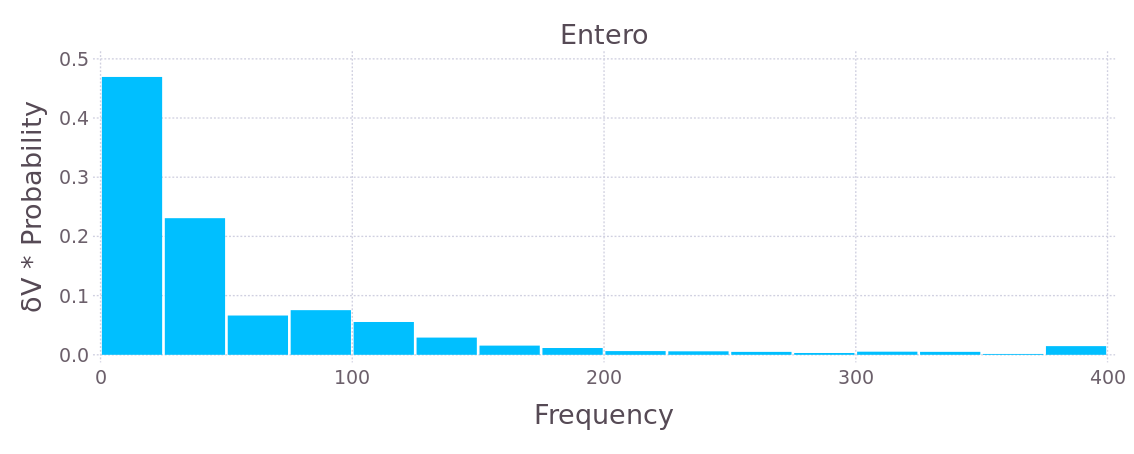

In [11]:
# Los bins van de 0 a la fqcia más alta + 10%
top_evals = maximum(evals_1ael)
bins_evals = collect(0:25:400)

# Histograma ponderado
Whis_evals_1ael, Wbins_evals_1ael = WeightedHist(evals_1ael, bins_evals, abs.(vgv_1ael), true);
df_Whis_evals_1ael = DataFrame(Probability = Whis_evals_1ael, Frequency = Wbins_evals_1ael);


pdf_Whis_evals_1ael = plot(df_Whis_evals_1ael, x="Frequency", y="Probability", Geom.bar,
    Guide.title("Entero"),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# Colectividad

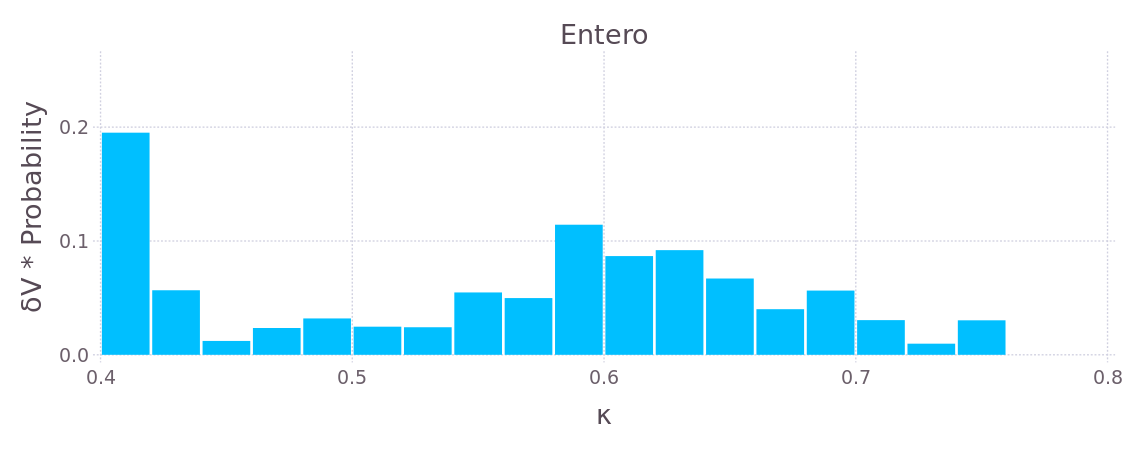

In [12]:
# Los bins van de 0 a la fqcia más alta + 10%
top_κ = maximum(κ_modes_1ael)
bins_κ = collect(0.4:.02:.8)

# Histograma ponderado
Whis_κ_1ael, Wbins_κ_1ael = WeightedHist(κ_modes_1ael, bins_κ, abs.(vgv_1ael), true);
df_Whis_κ_1ael = DataFrame(Probability = Whis_κ_1ael, κ = Wbins_κ_1ael);

pdf_Whis_κ_1ael = plot(df_Whis_κ_1ael, x="κ", y="Probability", Geom.bar,
    Guide.title("Entero"),
    Coord.cartesian(ymax = 0.26),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

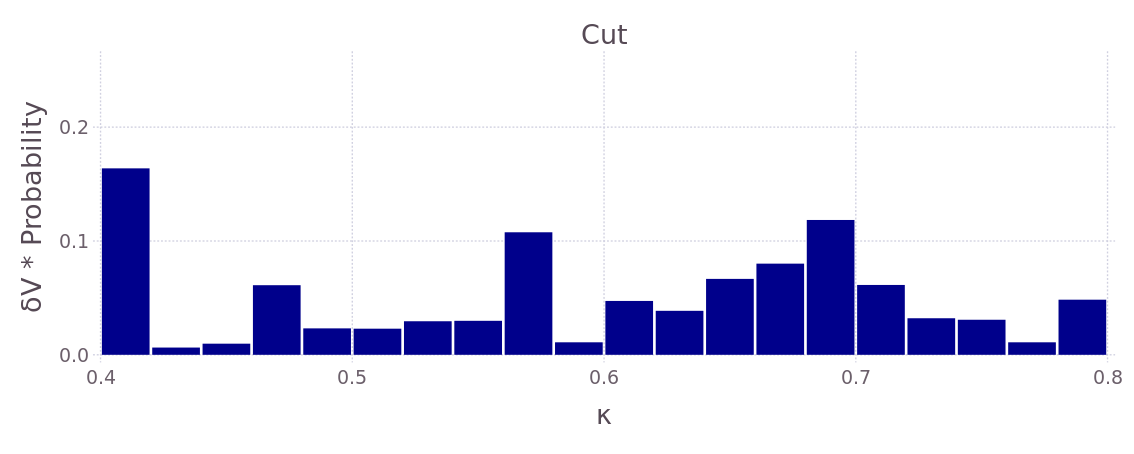

In [13]:
# Uso los bins del anterior
# Histograma ponderado
Whis_κ_cut_1ael, Wbins_κ_cut_1ael = WeightedHist(κ_modes_cut_1ael, bins_κ, abs.(vgv_1ael), true);
df_Whis_κ_cut_1ael = DataFrame(Probability = Whis_κ_cut_1ael, κ = Wbins_κ_cut_1ael);

pdf_Whis_κ_cut_1ael = plot(df_Whis_κ_cut_1ael, x="κ", y="Probability", Geom.bar,
    Guide.title("Cut"),
    Coord.cartesian(ymax = 0.26),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# Colectividad en pnumber

### Modos enteros

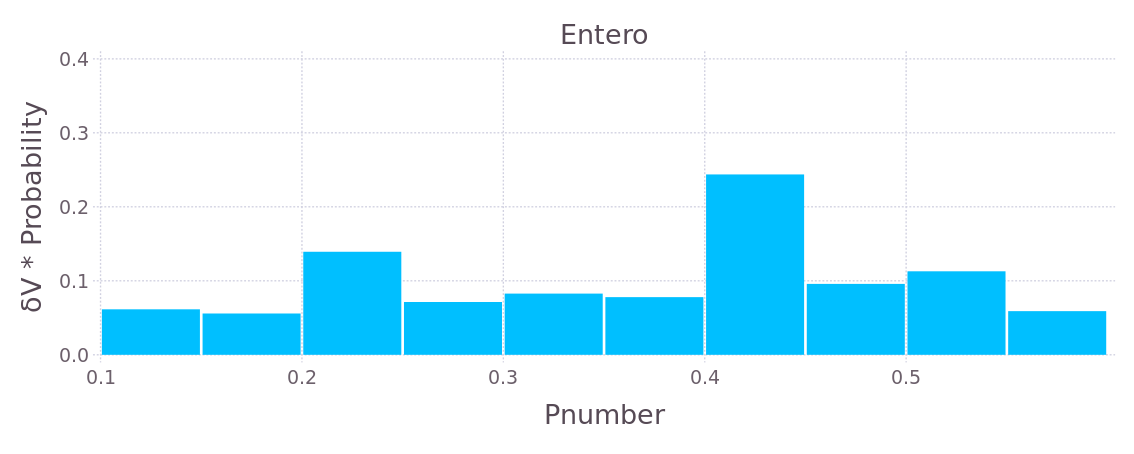

In [14]:
# Los bins van de 0 a la fqcia más alta + 10%
top_col = maximum(col_modes_1ael)
bins_col = collect(0.1:.05:.6)

# Histograma ponderado
Whis_col_1ael, Wbins_col_1ael = WeightedHist(col_modes_1ael, bins_col, abs.(vgv_1ael), true);
df_Whis_col_1ael = DataFrame(Probability = Whis_col_1ael, Pnumber = Wbins_col_1ael);

pdf_Whis_col_1ael = plot(df_Whis_col_1ael, x="Pnumber", y="Probability", Geom.bar,
    Guide.title("Entero"),
    Coord.cartesian(xmin = 0.1, ymax = 0.4),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
    # Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

### Modos recortados

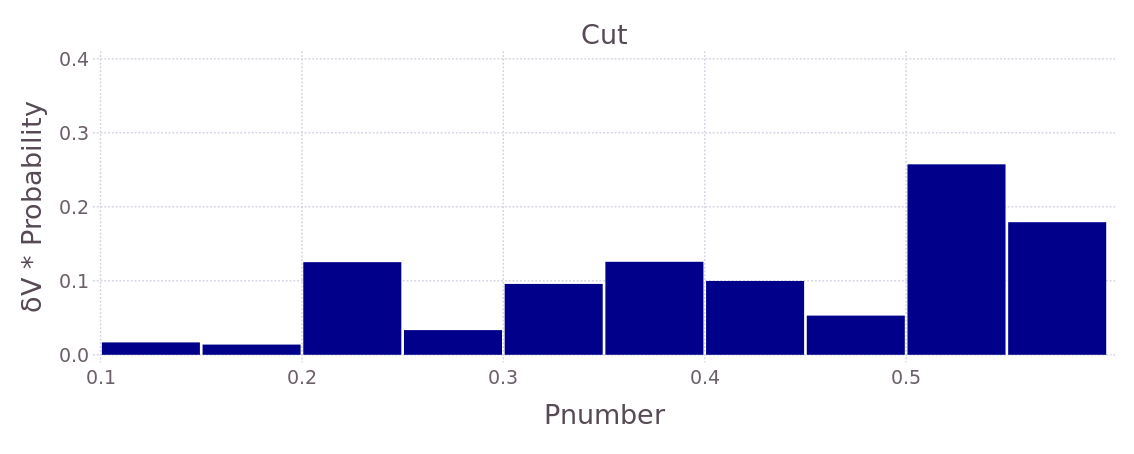

In [15]:
# Uso los bins de arriba
# Histograma ponderado
    Whis_col_cut_1ael, Wbins_col_cut_1ael = WeightedHist(col_modes_cut_1ael, bins_col, abs.(vgv_1ael), true);
df_Whis_col_cut_1ael = DataFrame(Probability = Whis_col_cut_1ael, Pnumber = Wbins_col_cut_1ael);

pdf_Whis_col_cut_1ael = plot(df_Whis_col_cut_1ael, x="Pnumber", y="Probability", Geom.bar,
    Guide.title("Cut"),
    Coord.cartesian(xmin = 0.1, ymax = 0.4),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# AAs de la pared

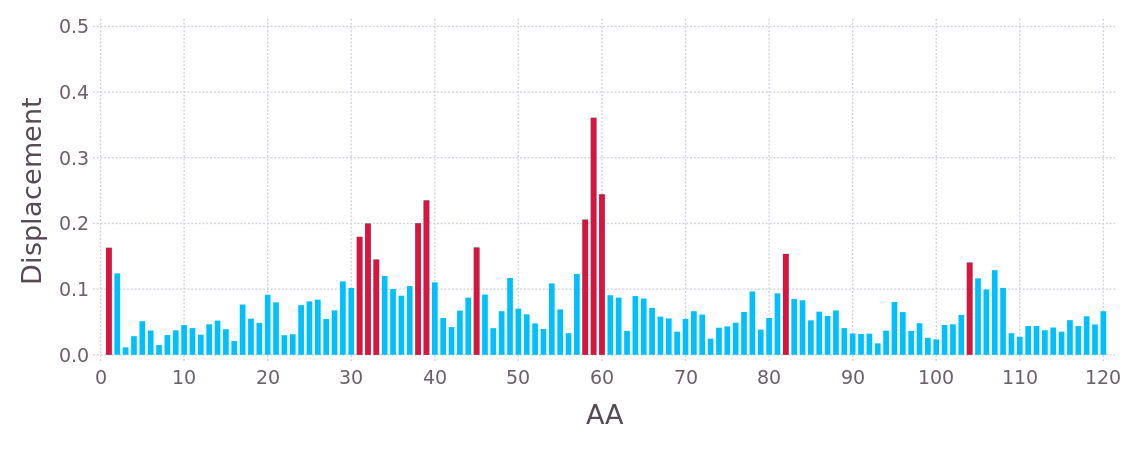

In [16]:
tmp = abs.(xyz_vgv_1ael)
tmp_ = copy(tmp)
tmp_[tmp_ .< .13] .= 0.

layer_temp_1 = layer(DataFrame(Displacement = tmp), Geom.bar, y = "Displacement")
layer_temp_2 = layer(DataFrame(Displacement = tmp_), Geom.bar, y = "Displacement",
Theme(default_color=colorant"crimson", bar_spacing=2pt))


pdf_cart_gdte = plot(layer_temp_2, layer_temp_1,
    Guide.xlabel("AA"),
    Guide.ylabel("Displacement"), Coord.cartesian(ymax = 0.5),
    Guide.xticks(ticks=collect(0:10:120)),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt,
        key_label_font_size = 15pt))

## Volumen de la trayectoria

In [31]:
trj_vol = convert(Array{Float64, 1}, readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);
df_trj_vol = DataFrame(Volume = trj_vol, Time = collect(1:length(trj_vol)));

bin_vol = collect(100:25:700)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Whis_vol_1ael, Wbins_vol_1ael = WeightedHist(trj_vol, bin_vol, wgh_vol, true, false);
df_Whis_vol_1ael = DataFrame(Probability = Whis_vol_1ael, Volume = Wbins_vol_1ael);

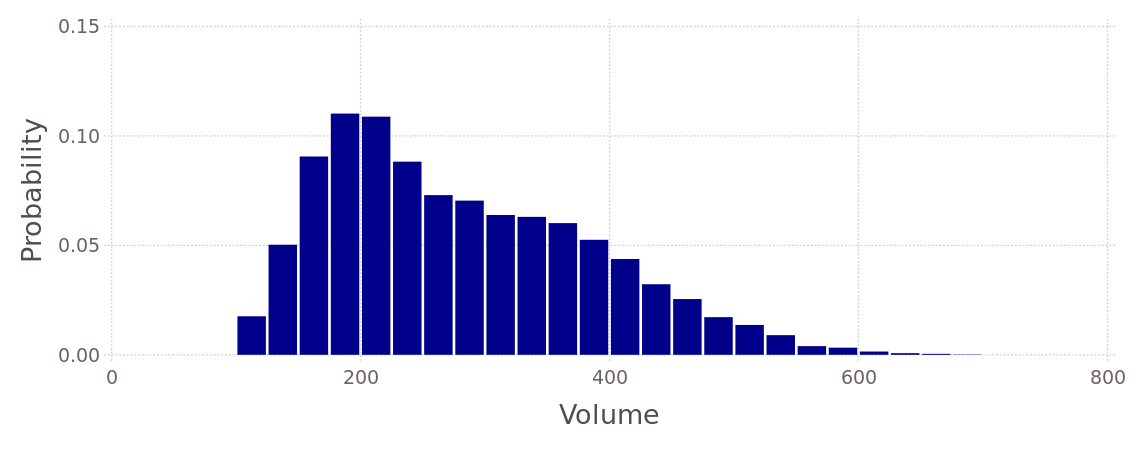

In [32]:
pdf_Whis_vol = plot(df_Whis_vol_1ael, x = "Volume", y = "Probability", Geom.bar,
    #Guide.title("Cut"),
    #Coord.cartesian(xmin = 500, xmax = 1710, ymax = 0.02),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks = collect(500:100:1700)),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

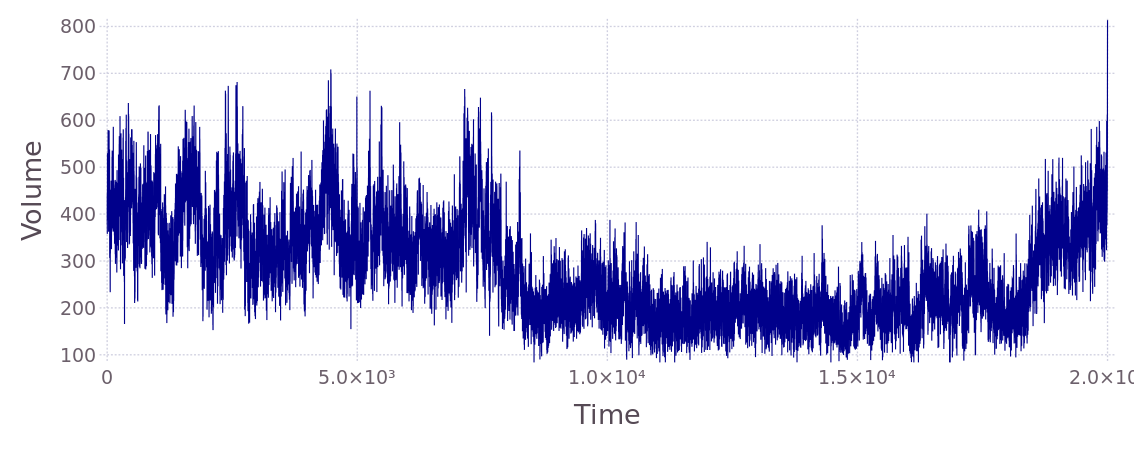

In [36]:
pdf_trj_vol = plot(df_trj_vol, x = "Time", y = "Volume",
    Geom.line,
    #Geom.smooth(method=:loess,smoothing=0.001),
    #Guide.title("Cut"),

    Coord.cartesian(xmin = 0, xmax = 20000, ymin = 100, ymax = 800),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

In [37]:
[ mean(trj_vol) ; std(trj_vol) ]

2-element Array{Float64,1}:
 280.796
 105.801

# Energía

In [38]:
points = 21
maxi = floor(points / 2)
mini = -maxi
RT = 0.693

E_1ael = Array{Float64,1}(points)
i = 0
for d = mini:maxi
    i+=1
    E_1ael[i] = energia_gdte(evals_1ael, vgv_1ael, d * 5E-1)
end

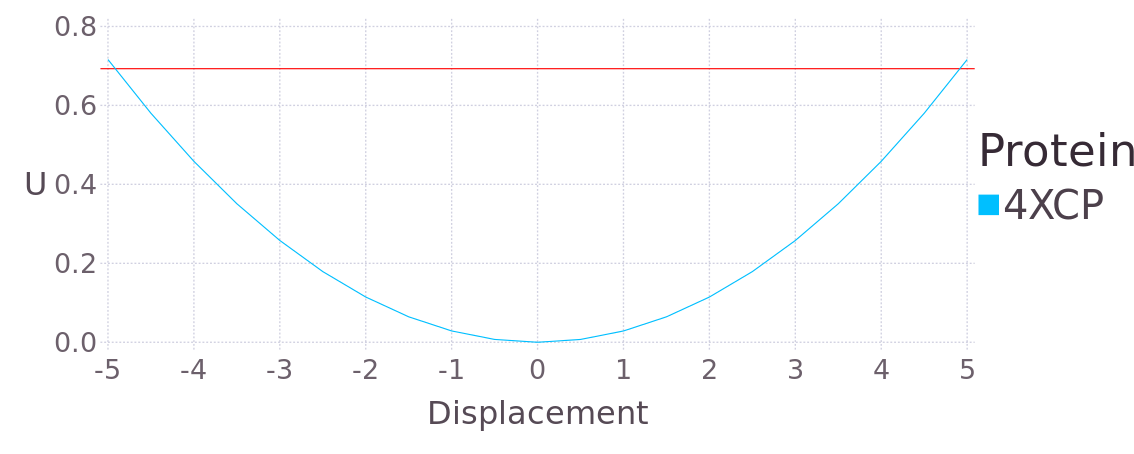

In [39]:
# Compilo en un dataframe.
df_E = DataFrame(U = E_1ael,
    Displacement = repeat(collect(mini:1:maxi) * 5E-1, outer = [1]), 
    Protein = fill("4XCP", points))

pdf_E = plot(df_E, y = "U", x = "Displacement", color = "Protein", Geom.line,
    yintercept = [RT], Geom.hline(color = "red"),
    Guide.xticks(ticks = collect(mini:2:maxi) * 5e-1),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
        key_label_font_size = 30pt))

## Ajuste de volumen a 2 gaussianas

In [40]:
gg = GMM(2, 1)
gg.μ[1, 1] = 200. 
gg.μ[2, 1] = 310. 
gg.Σ[1, 1] = 50
gg.Σ[2, 1] = 75
em!(gg, reshape(trj_vol, length(trj_vol), 1), nIter = 30);

In [72]:
lf_normal = Normal(gg.μ[1], sqrt(gg.Σ[1]))
lf_sampl = rand(lf_normal, 1000000)

lb_normal = Normal(gg.μ[2], sqrt(gg.Σ[2]))
lb_sampl = rand(lb_normal, 1000000);

bin_nor = collect(50:10:700)
wgh_nor = fill(1.0, length(lf_sampl))

# Histograma ponderado
Whis_nor_lf, Wbins_nor_lf = WeightedHist(lf_sampl, bin_nor, wgh_nor, true, false);
df_Whis_nor_lf = DataFrame(Probability = Whis_nor_lf .* 1.2, Volume = Wbins_nor_lf)

# Histograma ponderado
Whis_nor_lb, Wbins_nor_lb = WeightedHist(lb_sampl, bin_nor, wgh_nor, true, false);
df_Whis_nor_lb = DataFrame(Probability = Whis_nor_lb .* 1.5, Volume = Wbins_nor_lb)
    
df_Whis_nor = DataFrame(Probability = [ Whis_nor_lf ; Whis_nor_lb ],
    Volume = [ Wbins_nor_lf ; Wbins_nor_lb],
    Conformer = repeat(["LV" ; "HV"], inner = length(Wbins_nor_lb)));

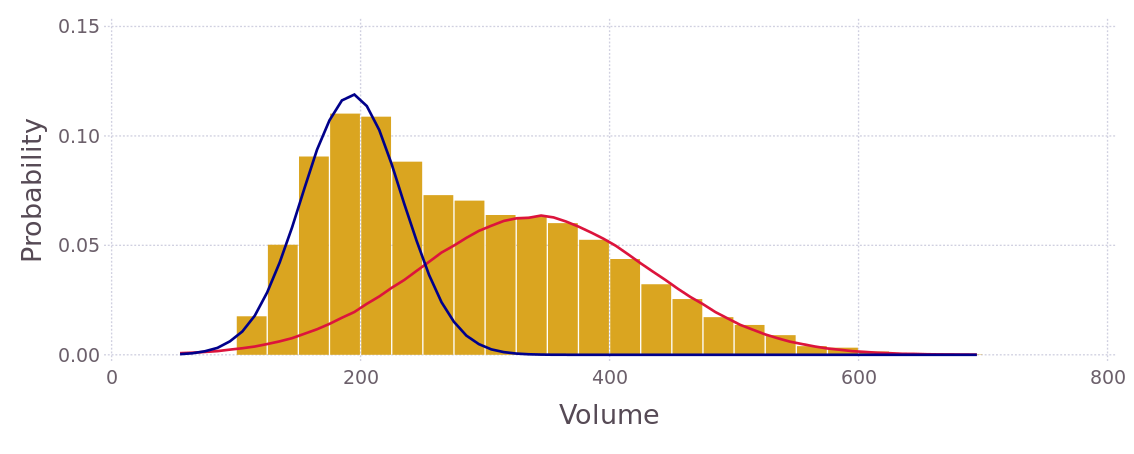

In [73]:
lyr_nor_lf = layer(df_Whis_nor_lf, x = "Volume", y = "Probability",
    Geom.line,
    Theme(default_color=colorant"DarkBlue", line_width = 2pt))
lyr_nor_lb = layer(df_Whis_nor_lb, x = "Volume", y = "Probability",
    Geom.line,
    Theme(default_color=colorant"Crimson", line_width = 2pt))
lyr_vol_1ael = layer(df_Whis_vol_1ael, x = "Volume", y = "Probability",
    Geom.bar,
    Theme(bar_spacing=1pt, default_color=colorant"GoldenRod"))

pdf_Whis_vol = plot(lyr_nor_lf, lyr_nor_lb, lyr_vol_1ael,
    #Guide.title("Cut"),
    #Coord.cartesian(xmin = 300, xmax = 1800, ymax = 0.002),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks = collect(500:100:1600)),
    
    Theme(grid_line_width = 1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# PCA projección

#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

#### Leo los vectores diferencia y los normalizo

In [78]:
diff_1ael = readdlm(joinpath(rtdos, "diff_1ael"))
nframes = size(diff_1ael)[2]
norm_diff_1ael = mapslices(x -> x ./ norm(x), diff_1ael, 1);

#### Obtengo las proyecciónes de vectores diferencia sobre los 1eros PCA

In [81]:
prj_1_1ael = Array{Float64, 1}(nframes)
prj_2_1ael = Array{Float64, 1}(nframes)

for i = 1:nframes
    prj_1_1ael[i] = dot(norm_diff_1ael[:, i], modes_1ael[:, 1])
    prj_2_1ael[i] = dot(norm_diff_1ael[:, i], modes_1ael[:, 2])
end

df_prj_1ael = DataFrame(PCA1 = prj_1_1ael, PCA2 = prj_2_1ael,
    Time = collect(1:length(prj_1_1ael)));

# Smooth
smooth_prj_1_1ael = [ mean(prj_1_1ael[i:i+10]) for i = 1:10:length(prj_1_1ael)-10 ]
smooth_prj_2_1ael = [ mean(prj_2_1ael[i:i+10]) for i = 1:10:length(prj_2_1ael)-10 ];

df_smooth_prj_1ael = DataFrame(PCA1 = smooth_prj_1_1ael, PCA2 = smooth_prj_2_1ael,
    Time = collect(1:length(smooth_prj_1_1ael)));

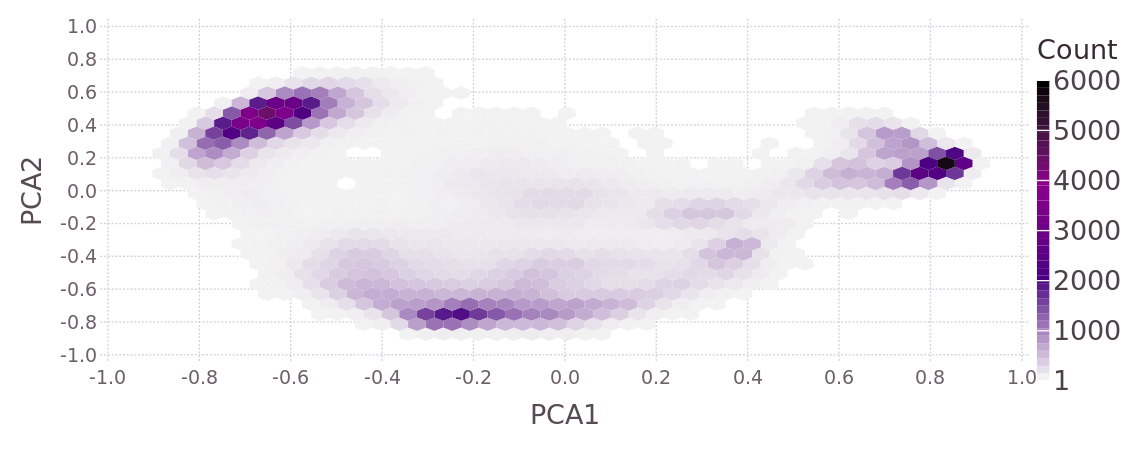

In [131]:
pdf_prj_1ael = plot(df_prj_1ael, x = "PCA1", y = "PCA2",
    #color = "Time",
    Geom.hexbin(xbincount = 80, ybincount = 40),
    #Geom.smooth(method=:loess,smoothing=0.001),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = -1., xmax = 1., ymin = -1., ymax = 1.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    Guide.xticks(ticks=collect(-1:.2:1)),
    Guide.yticks(ticks=collect(-1:.2:1)),
    
    Scale.color_continuous(colormap=Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),
    #Scale.color_continuous(minvalue = 100),
    #Scale.x_continuous(minvalue = 200),
    #Scale.y_continuous(minvalue = 200),
    
    Theme(bar_spacing=2pt, grid_line_width = 1pt, line_width = 2pt, point_size = 0.75pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

## Separo las poblaciones según PCA

In [121]:
in_bins = collect(-1:.025:1)
his_ind, his = MatHisInd2D(prj_1_1ael, prj_2_1ael, in_bins, in_bins);

msk = his .> 150;
spy(msk[25:50, 10:20])
spy(msk[65:80, 44:60])
spy(msk[5:25, 50:70])

idx_vol0 = collect(Iterators.flatten(his_ind[25:50, 10:20]))
idx_vol1 = collect(Iterators.flatten(his_ind[65:80, 44:60]))
idx_vol2 = collect(Iterators.flatten(his_ind[5:25, 50:70]));

full_trj_vol = Array{Float64, 1}(length(trj_vol) * 10)
for i = 1:length(trj_vol)
    k = (i - 1) * 10 + 1
    full_trj_vol[k:k+9] = fill(trj_vol[i], 10)
end

trj_vol0 = full_trj_vol[idx_vol0]
trj_vol1 = full_trj_vol[idx_vol1]
trj_vol2 = full_trj_vol[idx_vol2];

In [120]:
df_full_trj_vol = DataFrame(Volume = full_trj_vol ; Time = collect(1:length(full_trj_vol)))

plot(df_full_trj_vol, x = "Time", y = "Volume",
    Geom.line,
    #Geom.smooth(method=:loess,smoothing=0.001),
    #Guide.title("Cut"),

    Geom.vline(color = "Crimson"), xintercept = idx_vol0,
    
    #Coord.cartesian(xmin = 0, xmax = 20000, ymin = 200, ymax = 1800),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt));

In [124]:
plot(df_full_trj_vol, x = "Time", y = "Volume",
    Geom.line,
    #Geom.smooth(method=:loess,smoothing=0.001),
    #Guide.title("Cut"),

    Geom.vline(color = "Crimson"), xintercept = idx_vol1,
    
    #Coord.cartesian(xmin = 0, xmax = 20000, ymin = 200, ymax = 1800),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt));

In [127]:
plot(df_full_trj_vol, x = "Time", y = "Volume",
    Geom.line,
    #Geom.smooth(method=:loess,smoothing=0.001),
    #Guide.title("Cut"),

    Geom.vline(color = "Crimson"), xintercept = idx_vol2,
    
    #Coord.cartesian(xmin = 0, xmax = 20000, ymin = 200, ymax = 1800),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt));

In [136]:
bin_vol = collect(100:10:600)
# Histograma ponderado
wgh_vol = fill(1.0, length(trj_vol0))
Whis_vol0_1ael, Wbins_vol0_1ael = WeightedHist(trj_vol0, bin_vol, wgh_vol, true, false);
wgh_vol = fill(1.0, length(trj_vol1))
Whis_vol1_1ael, Wbins_vol1_1ael = WeightedHist(trj_vol1, bin_vol, wgh_vol, true, false);
wgh_vol = fill(1.0, length(trj_vol2))
Whis_vol2_1ael, Wbins_vol2_1ael = WeightedHist(trj_vol2, bin_vol, wgh_vol, true, false);

df_Whis_vol_str = DataFrame(Probability = [ Whis_vol0_1ael ; Whis_vol1_1ael ; Whis_vol2_1ael ],
    Volume = [ Wbins_vol0_1ael ; Wbins_vol1_1ael ; Wbins_vol2_1ael ],
    Conformer = [ fill("HV", length(Whis_vol0_1ael)) ;
        fill("LV1", length(Whis_vol1_1ael)) ; fill("LV2", length(Whis_vol2_1ael)) ]);

pdf_Whis_vol_str = plot(df_Whis_vol_str, x = "Volume", y = "Probability", color = "Conformer",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),
    #Coord.cartesian(xmin = 500, xmax = 1710),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks = collect(500:100:1700)),

    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

In [135]:
DataFrame(MEAN = [ mean(trj_vol0) ; mean(trj_vol1) ; mean(trj_vol2) ],
    STD = [ std(trj_vol0) ; std(trj_vol1) ; std(trj_vol2) ])

3×2 DataFrames.DataFrame
│ Row │ MEAN    │ STD     │
├─────┼─────────┼─────────┤
│ 1   │ 359.279 │ 80.821  │
│ 2   │ 269.556 │ 92.57   │
│ 3   │ 201.307 │ 49.2531 │

## No están bien separadas. No haría esto.

In [139]:
in_trj = Trajectory(joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")))
# Volume 0
trj_out_vol0 = Trajectory(joinpath(home, pdb, string("poblaciones/vol0_", pdb, ".nc")), 'w')
for i = 1:10:length(idx_vol0)
    in_frm = read_step(in_trj, idx_vol0[i] - 1)
    write(trj_out_vol0, in_frm)
end
close(trj_out_vol0)
# Volume 1
trj_out_vol1 = Trajectory(joinpath(home, pdb, string("poblaciones/vol1_", pdb, ".nc")), 'w')
for i = 1:10:length(idx_vol1)
    in_frm = read_step(in_trj, idx_vol1[i] - 1)
    write(trj_out_vol1, in_frm)
end
close(trj_out_vol1)
# Volume 2
trj_out_vol2 = Trajectory(joinpath(home, pdb, string("poblaciones/vol2_", pdb, ".nc")), 'w')
for i = 1:10:length(idx_vol2)
    in_frm = read_step(in_trj, idx_vol2[i] - 1)
    write(trj_out_vol2, in_frm)
end
close(trj_out_vol2)

In [143]:
# Frecuencias
car_vgmodes_1aelmodes_1aelv_1ael = modes_1ael * vgv_1ael
writetable(joinpath(rtdos, "freq_hist_1ael"), df_Whis_evals_1ael, separator = '\t')

# VGV cartesiano
car_vgv_1ael = modes_1ael * vgv_1ael
writedlm(joinpath(rtdos, "car_vgv_1ael"), car_vgv_1ael)

# Volumen
writetable(joinpath(rtdos, "vol_1ael"), df_trj_vol, separator = '\t')

# Histograma de volumen
writetable(joinpath(rtdos, "hist_vol_1ael"), df_Whis_vol_1ael, separator = '\t')

# Energías
writedlm(joinpath(rtdos, "energia_1ael"), E_1ael)